### Student Name: Aidan Keeshan
### Student ID: 18200117

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.datasets import make_moons
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import math
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import seaborn as sns

## Import CSV

In [3]:
df = pd.read_csv("bank_et2.csv",index_col=['Unnamed: 0'])
"|".join(df.columns.values)

'age|job|marital|education|default|balance|ratio_bal_ln|ratio_ln_inc|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|subscribed'

### Top 5 Records

In [4]:
df.head(5)

,age,job,marital,education,default,balance,ratio_bal_ln,ratio_ln_inc,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
0,32.0,technician,single,tertiary,no,392,1.300134,0.473895,yes,no,cellular,1,apr,957,2,131,2,failure,no
1,39.0,technician,divorced,secondary,no,688,-0.193701,0.237021,yes,yes,cellular,1,apr,233,2,133,1,failure,no
2,59.0,retired,married,secondary,no,1035,1.334266,0.121981,yes,yes,cellular,1,apr,126,2,239,1,failure,no
3,47.0,blue-collar,married,secondary,no,398,0.362286,1.251328,yes,yes,cellular,1,apr,274,1,238,2,failure,no
4,54.0,retired,married,secondary,no,1004,0.072075,-0.533738,yes,no,cellular,1,apr,479,1,307,1,failure,no


In [5]:
df_null = df.isnull().sum()
nunique = df.nunique()
df_null = pd.DataFrame({'VARNAME' : df_null.index.values, 'VARNULL': df_null.reset_index(drop=True),'VARDIS': nunique.reset_index(drop=True)}).sort_values(by=['VARNULL'], ascending=False)
df_null['VARDIST'] = (df_null['VARNULL']/2000)*df_null['VARDIS']
df_null = df_null[df_null['VARNULL'] != 0]
df_null['DQSCORE'] = df_null['VARDIST'] / df_null['VARDIST'].sum()
print (df_null)

      VARNAME  VARNULL  VARDIS  VARDIST   DQSCORE
17   poutcome      454       3    0.681  0.456740
10    contact      191       2    0.191  0.128102
3   education      104       3    0.156  0.104628
0         age       12      68    0.408  0.273642
1         job       10      11    0.055  0.036888


## Task 3 - Required pre Task 1

The variable I would like to define is a data quality score.   
I have not reviewed methods for deriving this but like a single metric which give me an indication of how much and which fields have been update per record (DQSCORE).    
It has been scaled to 1 which means a record is missing no variable. The VARDIS is used to identify how many unique values are in the var to be updated.   
This gives indication how much information is in the variable and conversely is missing for the record. I have scaled based on the number of records per missing VARDIST.   
This is to offset the information derived from average functions of populating mean/mode.  The DQSCORE must be populated before the values are updated.

In [6]:
# Initialise DQSCORE to zero assuming no missing information per record. 
df['DQSCORE'] = 1.0
for index, row in df_null.iterrows():
    # Remove per row where the varaible is missing
    df.loc[df[row['VARNAME']].isnull(),'DQSCORE'] -= row['DQSCORE']

print ("Data Points Missing: {} , Records Misisng Data: {}".format(df_null['VARNULL'].sum(),len(df[df['DQSCORE'] != 1])))
print (df['DQSCORE'].value_counts())

Data Points Missing: 771 , Records Misisng Data: 548
1.000000    1452
0.543260     246
0.415158     175
0.895372      69
0.438632      21
0.726358      11
0.310530       8
0.871898       6
0.858484       4
0.963112       3
0.767270       1
0.269618       1
0.506372       1
0.378270       1
0.401744       1
Name: DQSCORE, dtype: int64


It can be seen that some records have more than one varaible.   
There are 771 data points missing spread across the 5 varaibles but only 548 recors impacted.

## Task 1 (CS5062)

I have listed all fields which have nulls in them. I have not considered zero as null for this analysis,   
As not 100% clear which is the best approach, I have taken one value at this time to perform analysis on it (Age).  
To assess what is considered a better outcome I have taken the target variable subscribed and created 5 variation of age and used feature importance.    
As there will be massive collinearity between these values the outputs are largely irrelevant.    
I am assuming the largest one can best explain the variation in the target variable.    
In this case would show replace the average of age by marital status. 

In [7]:
table = df.pivot_table(values='age',columns='marital',aggfunc=np.median)
print(table)

marital  divorced  married  single
age          46.0     44.0    31.0


In [8]:
from sklearn.ensemble import ExtraTreesClassifier

y = df['subscribed'].map(dict(yes=1, no=0))
X = df[['age']]

X['age_by_marital'] = df['age'].fillna(df.groupby('marital')['age'].transform('mean'))
X['age_by_job'] = df['age'].fillna(df.groupby('job')['age'].transform('mean'))
X['age_by_education'] = df['age'].fillna(df.groupby('education')['age'].transform('mean'))

X['age_mean'] = X['age'].fillna(X['age'].mean())
X['age_zero'] = X['age'].fillna(0)

X = X.drop(['age'], axis=1)

model = ExtraTreesClassifier()
model.fit(X, y)
fet_imp = model.feature_importances_

fet_imp = pd.DataFrame({'TRANSFORM':X.columns.values,'FEATURE_IMPORTANCE':fet_imp})
fet_imp

,TRANSFORM,FEATURE_IMPORTANCE
0,age_by_marital,0.113356
1,age_by_job,0.206477
2,age_by_education,0.241075
3,age_mean,0.291609
4,age_zero,0.147483


In [9]:
# poutcome has the most missing values and we know little about its impact. Impute to new varaible
df.loc[df['poutcome'].isnull(), 'poutcome'] = "unknown"
# Could drop records but will leave and see if DQSCORE impacts.
df.loc[df['job'].isnull(), 'job'] = "other"
# Inspired by Michel code looked for slight varation
# Source https://stackoverflow.com/questions/46532986/filling-missing-values-of-categorical-values-based-on-other-categorical-values-i
df['education'] = df.groupby('job').education.transform(lambda x: x.fillna(x.mode()[0]))
# Age as per analysis above
df['age'] = df['age'].fillna(df.groupby('marital')['age'].transform('mean'))

var_name = 'contact'
var_dist = df[var_name].value_counts(normalize=True)
df[var_name] = df[var_name].fillna(pd.Series(np.random.choice(var_dist.index.values,p=var_dist, size=len(df))))
# Test all varaible are now populated
df.isnull().sum()

age             0
job             0
marital         0
education       0
default         0
balance         0
ratio_bal_ln    0
ratio_ln_inc    0
housing         0
loan            0
contact         0
day             0
month           0
duration        0
campaign        0
pdays           0
previous        0
poutcome        0
subscribed      0
DQSCORE         0
dtype: int64

## Task 2/3 (CS5062)
I was clear in Etivity 1 that balance had extreme values.   
When apply log transform to there ens up being infiniate NaN for negative values  
and Inf for zero. As others have pointed in forums not great for partioning across  
As per Gerard Murphy post have taken cubed roots for more consitent approach acroos negative anf minus. 
Transformed days to months as normal cycle timing for banking. 

In [10]:
df['balance_log']=np.log(df['balance']-df['balance'].min()+1)
df['balance_cubed']=df['balance']**(1/3)
df['balance_cubed']=df['balance_cubed'].fillna(0)
df['pmnths']=(df['pdays']-df['pdays'].min())/30
df.describe()

,age,balance,ratio_bal_ln,ratio_ln_inc,day,duration,campaign,pdays,previous,DQSCORE,balance_log,balance_cubed,pmnths
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,41.751526,1413.663500,0.241951,0.485030,13.851500,292.020500,1.909500,167.896000,2.561500,0.876819,7.510875,8.720299,5.629867
std,12.695113,3131.224213,0.821604,1.075543,9.712189,221.557295,1.378862,131.754126,3.400735,0.217525,0.651886,5.074802,4.391804
min,18.000000,-980.000000,-2.632068,-2.851405,1.000000,7.000000,1.000000,-1.000000,0.000000,0.269618,0.000000,0.000000,0.000000
25%,32.000000,201.500000,-0.308018,-0.274181,5.000000,146.000000,1.000000,75.750000,1.000000,0.895372,7.075386,5.862607,2.558333
50%,38.000000,551.000000,0.224099,0.487082,12.000000,236.000000,1.000000,182.000000,2.000000,1.000000,7.334329,8.198172,6.100000
75%,50.000000,1644.500000,0.806315,1.211896,23.000000,379.000000,2.000000,251.000000,3.000000,1.000000,7.873027,11.803513,8.400000
max,93.000000,81204.000000,2.961979,4.046914,31.000000,1823.000000,11.000000,854.000000,55.000000,1.000000,11.316728,43.303780,28.500000


In [11]:
df['iqr_count'] = 0
df['three_sigma_count'] = 0
# https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame
col_outlier = ['age','ratio_bal_ln','ratio_bal_ln','ratio_ln_inc','pmnths','balance_cubed']
for col_name in col_outlier:
    q1 = df[col_name].quantile(0.25)
    q3 = df[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df.loc[df[row['VARNAME']].isnull(),'DQSCORE'] -= row['DQSCORE']
    df.loc[(df[col_name] < fence_low) | (df[col_name] > fence_high),'iqr_count'] += 1
    df.loc[((df[col_name] - df[col_name].mean())/df[col_name].std()) > 3,'three_sigma_count'] += 1
df['outlier_count'] = df['iqr_count']+df['three_sigma_count']

print (df['iqr_count'].value_counts())
print (df['three_sigma_count'].value_counts())
print (df['outlier_count'].value_counts())

0    1892
1      91
2      15
3       2
Name: iqr_count, dtype: int64
0    1943
1      53
2       4
Name: three_sigma_count, dtype: int64
0    1892
2      63
1      39
4       5
3       1
Name: outlier_count, dtype: int64


## Task 3 (CS5062)
As per DQSCORE I have created variable which can idnicate if oulirers are in the dataset.   
Can be left in model to see if feture is optimise to minise error introduced by these. 
As the non outlier records do no have value (0) no beta can appliy for this feture.

It can be seen that this varaible makes the train score worse bu does not impact the test score.  
When the outlisers are excluded the tran score gets better by the test score is worse.   
As mentioned in the forums more analysis would be required to understand where the outlier end up.   
i.e. if by chance all outlier end up in test or train would impact model weights. 

## Task 4 (CE6002)
As data not fully prepared only working on subset currently

In [12]:
def prepare_data(X_col,y_col,exc_outlier=False):
    if exc_outlier:
        X = df[X_col][df.outlier_count == 0]
        y = df[y_col][df.outlier_count == 0].map(dict(yes=1, no=0))
    else:
        X = df[X_col]
        y = df[y_col].map(dict(yes=1, no=0))
    X = pd.get_dummies(X, columns=list(X.select_dtypes(include='object').columns), drop_first=True)
    return X,y

test_size = 0.3
num_iter = 1000

def plot_bound(es,nvar):
    dvc = nvar + 1
    e_diff = abs(np.array(es[:,0])-np.array(es[:,1]))
    epsilons = np.arange(0.001,0.20,0.001)
    prob_epsilon=[]
    for e in epsilons:
        prob_epsilon.append(len([1 for i in e_diff if i > e])/len(e_diff))
    plt.plot(epsilons, prob_epsilon, 'b')
    
    N = es.shape[0]
    
    hoef = [2*math.exp(-2*N*e**2) for e in epsilons]
    vc = [4*(((2*N)**dvc)+1)*math.exp(-(N/8)*e**2) for e in epsilons]
    
    print("Error exceeds Hoeffding" if max(np.array(prob_epsilon)-np.array(hoef))>0 else "Error does not exceed Hoeffding")
    print("Error exceeds VC" if max(np.array(prob_epsilon)-np.array(vc))>0 else "Error does not exceed VC")
    
    title = "Probability |Ein-Eout| is greater than Epsilon dVC = " + str(dvc)
    plt.title(title)
    plt.plot(epsilons, hoef,'r')
    plt.plot(epsilons, vc, 'g')
    plt.yscale('log')
    plt.xlabel('Epsilon')
    plt.show() 

def run_log_reg(X_col,y_col,exc_outlier=False):
    X,y = prepare_data(X_col,y_col,exc_outlier)
    error_series = np.zeros((num_iter,2))
    for i in range(num_iter):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
        clf = LogisticRegression(n_jobs=8)
        clf.fit(X_train, y_train)
        error_series[i][0] = clf.score(X_train, y_train)
        error_series[i][1] = clf.score(X_test, y_test)
    plot_bound(error_series,X_train.shape[1])
    #print (run_info)
    print ("Train Score: {:.2%}".format(clf.score(X_train, y_train)))
    print ("Test Score: {:.2%}".format(clf.score(X_test, y_test)))

Error does not exceed Hoeffding
Error does not exceed VC


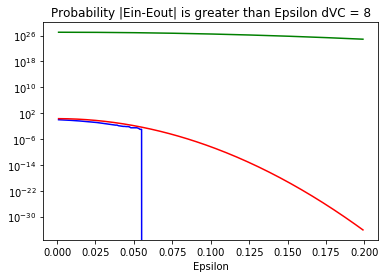

Train Score: 87.86%
Test Score: 87.50%


In [22]:
run_log_reg(["age","balance","ratio_bal_ln","ratio_ln_inc","poutcome"],'subscribed')

Error does not exceed Hoeffding
Error does not exceed VC


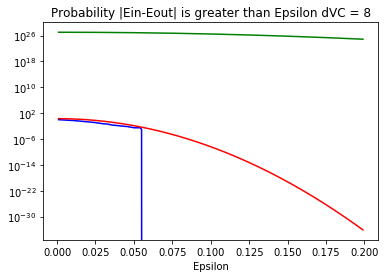

Train Score: 88.00%
Test Score: 87.17%


In [14]:
run_log_reg(["age","balance_log","ratio_bal_ln","ratio_ln_inc","poutcome"],'subscribed')

Error does not exceed Hoeffding
Error does not exceed VC


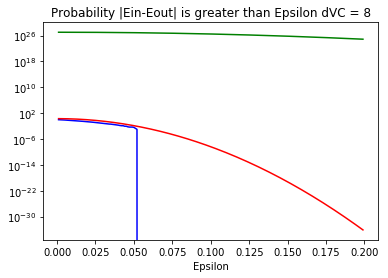

Train Score: 88.21%
Test Score: 88.50%


In [15]:
run_log_reg(["age","balance_cubed","ratio_bal_ln","ratio_ln_inc","poutcome"],'subscribed')

Error does not exceed Hoeffding
Error does not exceed VC


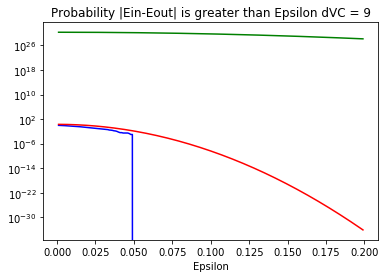

Train Score: 88.64%
Test Score: 87.67%


In [16]:
run_log_reg(["age","balance_cubed","ratio_bal_ln","ratio_ln_inc","poutcome","DQSCORE"],'subscribed')

Error does not exceed Hoeffding
Error does not exceed VC


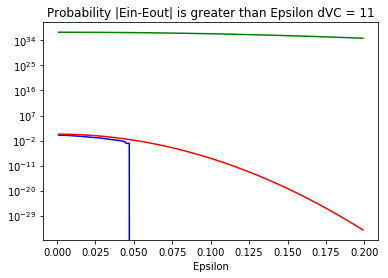

Train Score: 89.21%
Test Score: 87.00%


In [17]:
run_log_reg(["age","balance_cubed","ratio_bal_ln","ratio_ln_inc","poutcome","DQSCORE","iqr_count","three_sigma_count"],'subscribed')

Error does not exceed Hoeffding
Error does not exceed VC


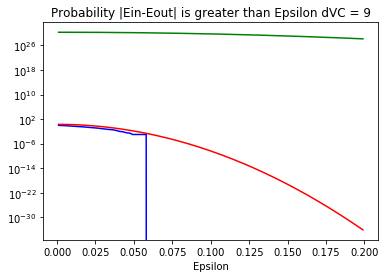

Train Score: 87.99%
Test Score: 89.61%


In [18]:
run_log_reg(["age","balance_cubed","ratio_bal_ln","ratio_ln_inc","poutcome","DQSCORE"],'subscribed',True)

Error does not exceed Hoeffding
Error does not exceed VC


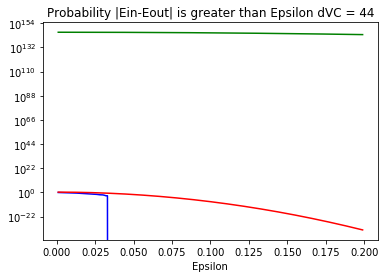

Train Score: 97.71%
Test Score: 96.00%


In [19]:
run_log_reg(["age","job","marital","education","default","ratio_bal_ln","ratio_ln_inc","housing","loan","contact","day","month","duration","campaign","pmnths","previous","poutcome","balance_cubed","DQSCORE"],'subscribed')

### Task 5 (CE6002)
Sample code taken form sklearn website

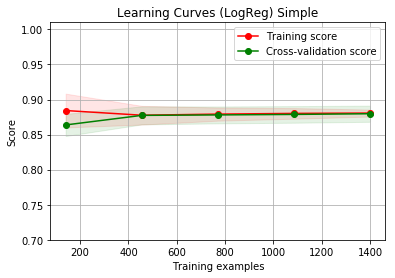

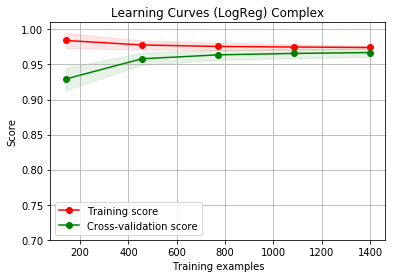

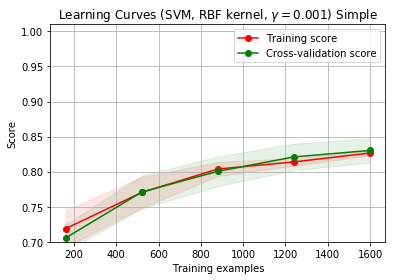

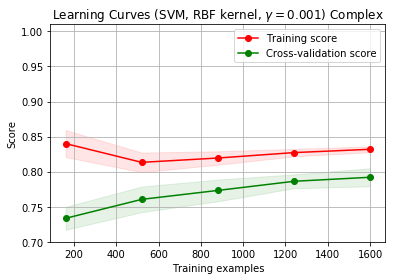

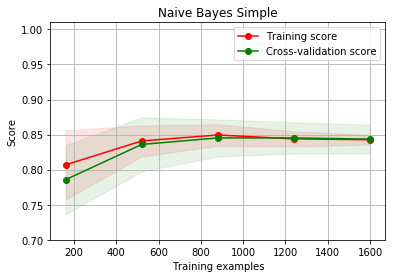

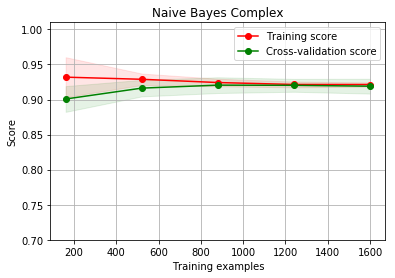

In [20]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


X, y = prepare_data(["age","balance_cubed","ratio_bal_ln","ratio_ln_inc","poutcome","DQSCORE"],'subscribed')
title = "Learning Curves (LogReg) Simple"
cv = ShuffleSplit(n_splits=100, test_size=0.3, random_state=42)
estimator = LogisticRegression()
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=8)

X, y = prepare_data(["age","job","marital","education","default","ratio_bal_ln","ratio_ln_inc","housing","loan","contact","day","month","duration","campaign","pmnths","previous","poutcome","balance_cubed","DQSCORE"],'subscribed')
title = "Learning Curves (LogReg) Complex"
cv = ShuffleSplit(n_splits=100, test_size=0.3, random_state=42)
estimator = LogisticRegression()
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=8)

X, y = prepare_data(["age","balance_cubed","ratio_bal_ln","ratio_ln_inc","poutcome","DQSCORE"],'subscribed')
title = "Learning Curves (SVM, RBF kernel, $\gamma=0.001$) Simple"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, X, y, (0.7, 1.01), cv=cv, n_jobs=8)

X, y = prepare_data(["age","job","marital","education","default","ratio_bal_ln","ratio_ln_inc","housing","loan","contact","day","month","duration","campaign","pmnths","previous","poutcome","balance_cubed","DQSCORE"],'subscribed')
title = "Learning Curves (SVM, RBF kernel, $\gamma=0.001$) Complex"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, X, y, (0.7, 1.01), cv=cv, n_jobs=8)

X, y = prepare_data(["age","balance_cubed","ratio_bal_ln","ratio_ln_inc","poutcome","DQSCORE"],'subscribed')
title = "Naive Bayes Simple"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = GaussianNB()
plot_learning_curve(estimator, title, X, y, (0.7, 1.01), cv=cv, n_jobs=8)

X, y = prepare_data(["age","job","marital","education","default","ratio_bal_ln","ratio_ln_inc","housing","loan","contact","day","month","duration","campaign","pmnths","previous","poutcome","balance_cubed","DQSCORE"],'subscribed')
title = "Naive Bayes Complex"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = GaussianNB()
plot_learning_curve(estimator, title, X, y, (0.7, 1.01), cv=cv, n_jobs=8)


plt.show()

### Conclusion
As can be seen form the all complex models. 
    The overall error in test data is reduced but takes longer to converge and there is greater variance between test and train (eout and ein).   
    In general the standard deviation on error in the simple model is wider and more narrow in the complex model.   
    
The Logistic regression model and has tighter range of error on train and test but does not converge.  
The Navies Bayes has wider standard deviation but does converge.   
This would indicate NB a simler model which generalise better would be counter intuitive as always assumed more complex.   

I do not know what conclusion to draw on SVM.   
I had changed to sigmoid activation but no graphs appear or nothing of sense.    
The more complex model in term of demsions dose worse with worse spread between ein and eout.    
Can only assume something to do hyper dimensional nature of nature of  SVM. Possible indication of shattering.


The logistic regression model generalises well on low complexity model.   